In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

In [263]:
filepath = "/content/drive/MyDrive/synthetic_ecommerce_data.csv"

In [264]:
df = pd.read_csv(filepath, parse_dates=['Transaction_Date'])

##EDA

In [265]:
df.head()

,Transaction_ID,Customer_ID,Product_ID,Transaction_Date,Units_Sold,Discount_Applied,Revenue,Clicks,Impressions,Conversion_Rate,Category,Region,Ad_CTR,Ad_CPC,Ad_Spend
0,8b460852-7c64-46fa-998b-b0976879d082,Customer_65,Product_224,2024-10-06,134,0.14,305.54,11,65,0.17,Electronics,Europe,0.0180,0.55,9.90
1,418612e7-8744-4ba3-bb0c-105b47e2a968,Customer_1910,Product_584,2024-10-29,109,0.30,1102.19,15,201,0.07,Home Appliances,Asia,0.1589,0.40,63.56
2,5bc3b98f-cb0c-4b12-947c-df8bbb35a73e,Customer_2306,Product_374,2024-04-04,116,0.04,471.29,16,199,0.08,Toys,Asia,0.0596,1.50,89.40
3,28fb67c8-e8c0-447a-841c-f760730de0eb,Customer_17206,Product_220,2024-08-25,125,0.20,980.26,12,355,0.03,Clothing,Europe,0.0444,0.44,19.54
4,8bee087a-a8a9-45bb-89d7-04d1710f1b00,Customer_16033,Product_358,2024-05-05,132,0.07,803.76,44,355,0.12,Books,North America,0.1270,0.53,67.31


In [266]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Transaction_ID    100000 non-null  object        
 1   Customer_ID       100000 non-null  object        
 2   Product_ID        100000 non-null  object        
 3   Transaction_Date  100000 non-null  datetime64[ns]
 4   Units_Sold        100000 non-null  int64         
 5   Discount_Applied  100000 non-null  float64       
 6   Revenue           100000 non-null  float64       
 7   Clicks            100000 non-null  int64         
 8   Impressions       100000 non-null  int64         
 9   Conversion_Rate   100000 non-null  float64       
 10  Category          100000 non-null  object        
 11  Region            100000 non-null  object        
 12  Ad_CTR            100000 non-null  float64       
 13  Ad_CPC            100000 non-null  float64       
 14  Ad_Sp

In [267]:
# nothing's missing lowkey, some cols are objects (categories to handle before training on)

In [268]:
df.isnull().sum()
# cinfirmed

,0
Transaction_ID,0
Customer_ID,0
Product_ID,0
Transaction_Date,0
Units_Sold,0
Discount_Applied,0
Revenue,0
Clicks,0
Impressions,0
Conversion_Rate,0


## Outlier detection
if they're outliers or justifiable data points

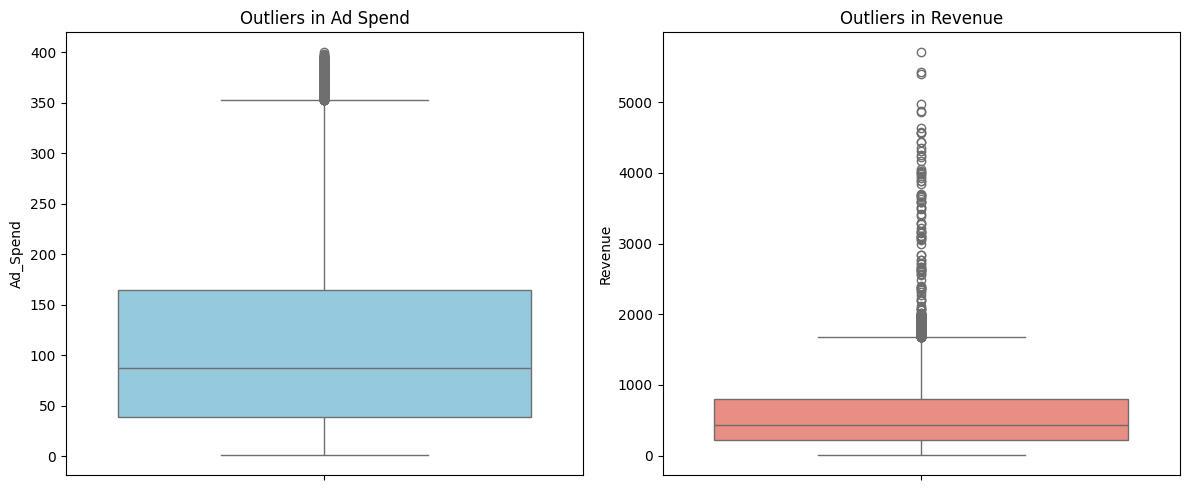

In [269]:
plt.figure(figsize=(12, 5))

# Plotting Ad Spend and Revenue outliers
plt.subplot(1, 2, 1)
sns.boxplot(y=df['Ad_Spend'], color='skyblue')
plt.title('Outliers in Ad Spend')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['Revenue'], color='salmon')
plt.title('Outliers in Revenue')

plt.tight_layout()
plt.show()

Several high-revenue data points are "outliers", think of a model that's robust to this situation

## Feature engineering

In [270]:
df['Month'] = df['Transaction_Date'].dt.month
df['DayOfWeek'] = df['Transaction_Date'].dt.dayofweek

In [271]:
# engineering the campaigns out of date, cat, region
data = df.groupby(['Transaction_Date', 'Category', 'Region', 'Month', 'DayOfWeek']).agg({
    'Ad_Spend': 'sum',
    'Clicks': 'sum',
    'Impressions': 'sum',
    'Revenue': 'sum',
    'Units_Sold': 'sum',
    'Ad_CTR': 'sum',
    'Ad_CPC': 'sum'
}).reset_index()

In [272]:
data['Spend_Efficiency'] = data['Ad_Spend'] * data['Clicks']

In [273]:
# features and y : target column
X = data[['Ad_Spend', 'Clicks', 'Impressions', 'Month', 'DayOfWeek', 'Category', 'Region', 'Spend_Efficiency', 'Ad_CTR', 'Ad_CPC']]
y = data['Revenue']

In [274]:
X

,Ad_Spend,Clicks,Impressions,Month,DayOfWeek,Category,Region,Spend_Efficiency,Ad_CTR,Ad_CPC
0,1837.26,389,3365,12,3,Books,Asia,714694.14,1.7724,14.73
1,2385.95,405,4477,12,3,Books,Europe,966309.75,2.1641,21.04
2,2910.23,517,6199,12,3,Books,North America,1504588.91,2.4176,25.41
3,2498.42,403,4692,12,3,Clothing,Asia,1006863.26,1.8217,22.01
4,1845.82,309,4542,12,3,Clothing,Europe,570358.38,1.6378,15.82
...,...,...,...,...,...,...,...,...,...,...
5485,2093.20,256,3343,12,4,Home Appliances,Europe,535859.20,1.7831,15.05
5486,2224.22,409,4165,12,4,Home Appliances,North America,909705.98,1.8374,19.01
5487,1797.73,430,5375,12,4,Toys,Asia,773023.90,1.8348,17.67
5488,1581.18,409,3015,12,4,Toys,Europe,646702.62,1.3716,16.09


In [275]:
# Encoding categories (transforming the Xs that are categories to numericals)
X = pd.get_dummies(X, columns=['Category', 'Region'], drop_first=True)
# X : as expected

In [276]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

print(f"Train size: {X_train.shape[0]}, Val size: {X_val.shape[0]}, Test size: {X_test.shape[0]}")

Train size: 3513, Val size: 879, Test size: 1098


## Further preprocessing
normalization, standardization

In [277]:
num_features = ['Ad_Spend', 'Clicks', 'Impressions', 'Month', 'DayOfWeek']

# scaler at work
scaler = StandardScaler()
# init the new X_train , y_train
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_features] = scaler.fit_transform(X_train[num_features])
X_val_scaled[num_features] = scaler.transform(X_val[num_features])
X_test_scaled[num_features] = scaler.transform(X_test[num_features])

## Marketing dynamics analysis

Correlation for Books: 0.59
Correlation for Clothing: 0.58
Correlation for Electronics: 0.58
Correlation for Home Appliances: 0.56
Correlation for Toys: 0.63


<Figure size 1000x600 with 0 Axes>

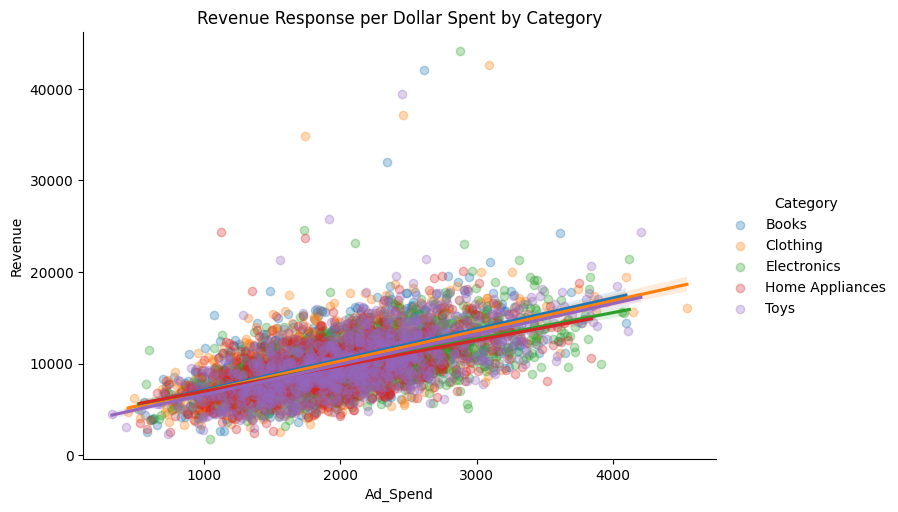

In [278]:
# correlation ? between category budget and revenue
for cat in data['Category'].unique():
    subset = data[data['Category'] == cat]
    correlation = subset['Ad_Spend'].corr(subset['Revenue'])
    print(f"Correlation for {cat}: {correlation:.2f}")


plt.figure(figsize=(10, 6))
sns.lmplot(x='Ad_Spend', y='Revenue', hue='Category', data=data, aspect=1.5, scatter_kws={'alpha':0.3})
plt.title('Revenue Response per Dollar Spent by Category')
plt.show()

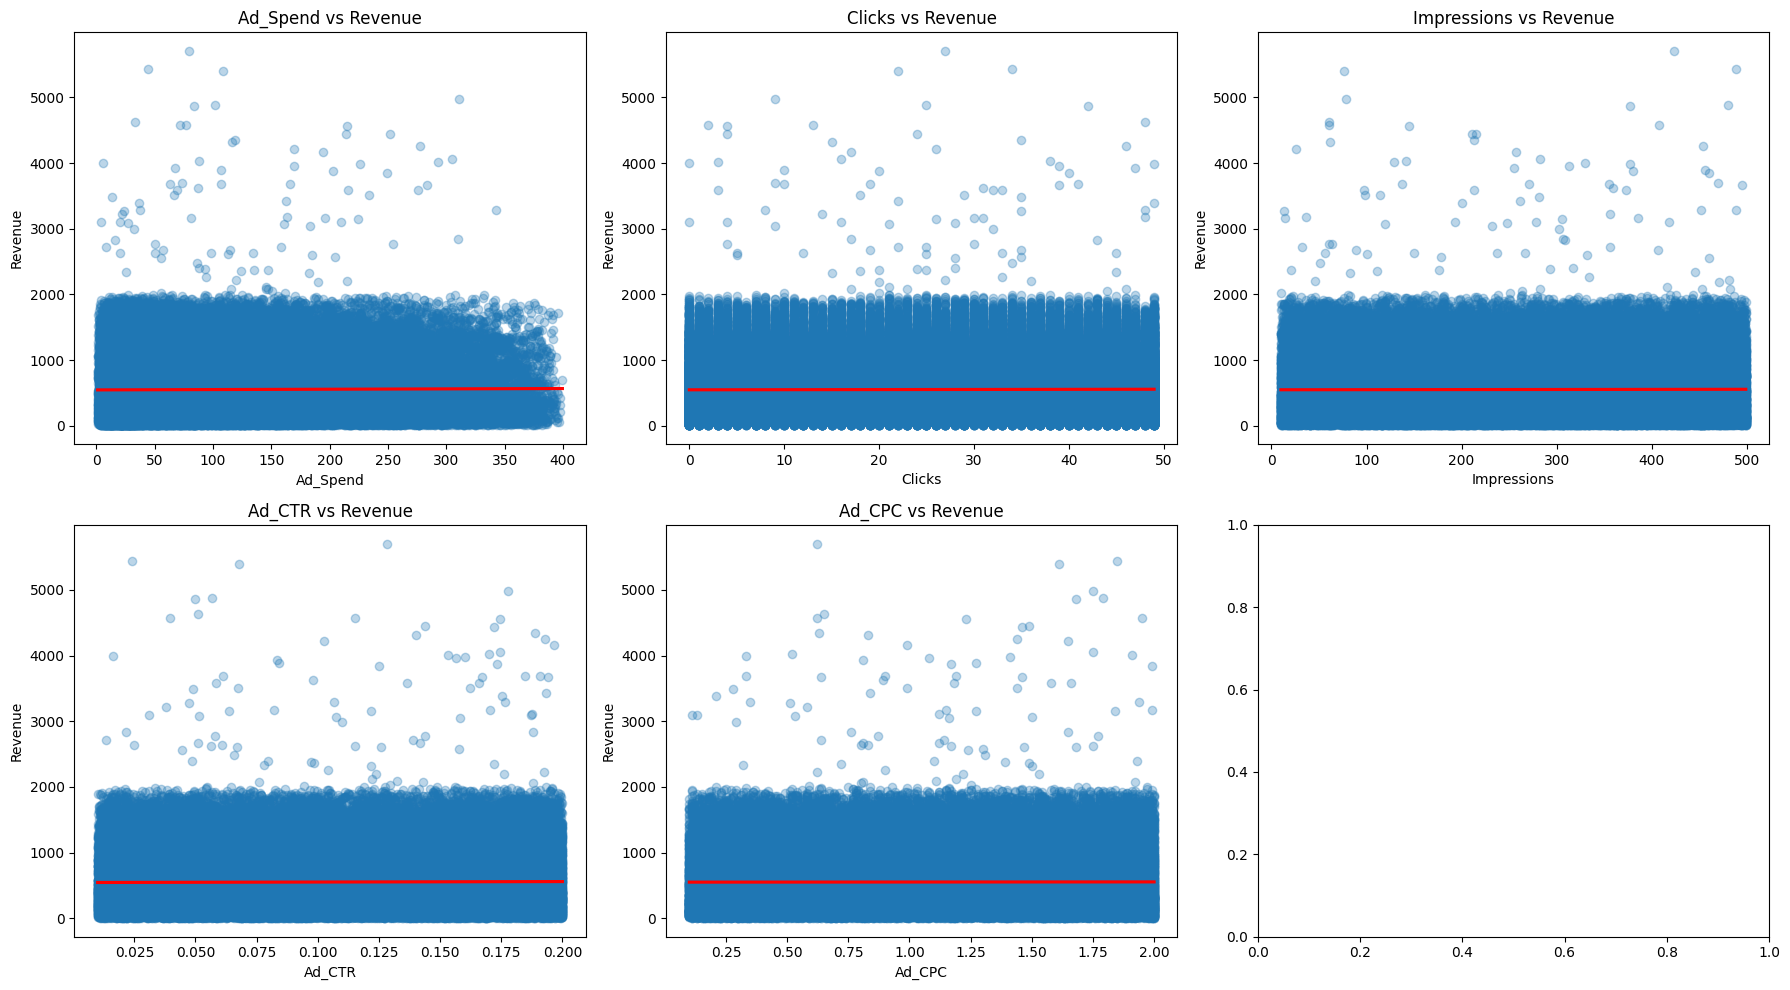

In [279]:
# List of numeric features to test
features_to_plot = ['Ad_Spend', 'Clicks', 'Impressions', 'Ad_CTR', 'Ad_CPC']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(features_to_plot):
    sns.regplot(data=df, x=col, y='Revenue', ax=axes[i],
                scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    axes[i].set_title(f'{col} vs Revenue')

plt.tight_layout()
plt.show()

In [280]:
# df.dtypes

## Global correlations

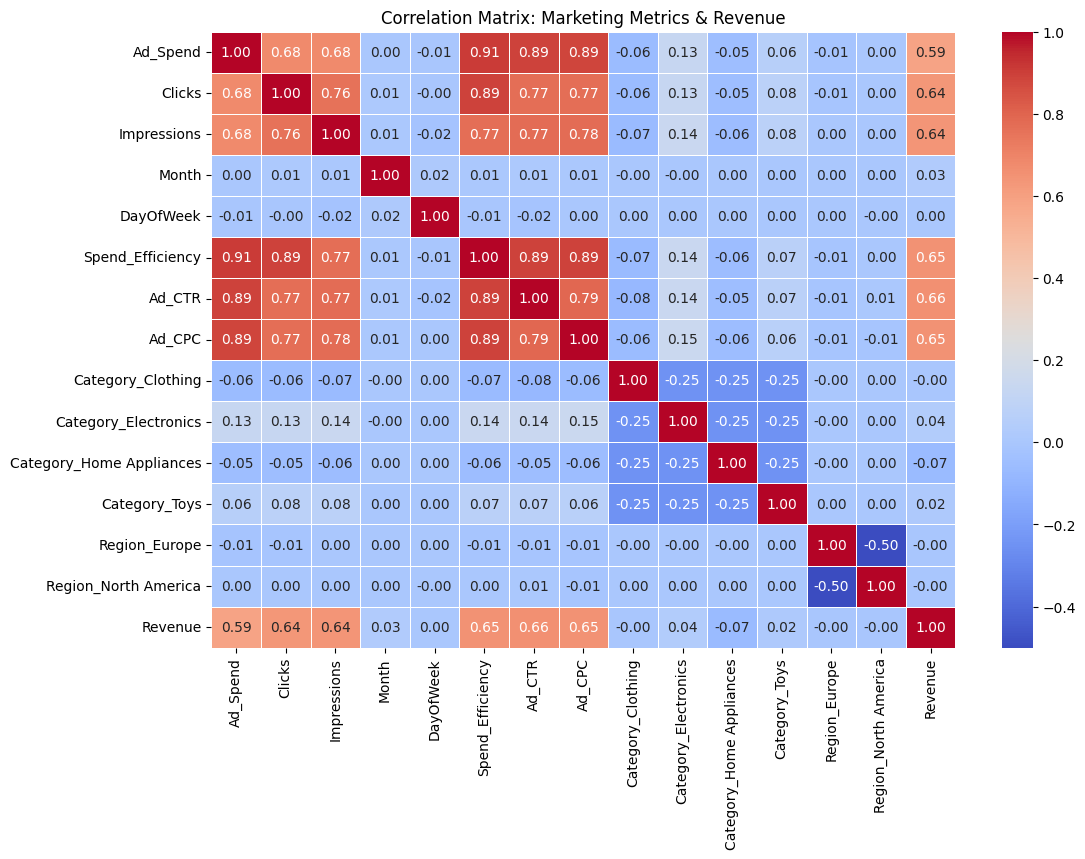

In [281]:
# cols_excluded_heat_map = ['Transaction_ID', 'Customer_ID', 'Transaction_Date', 'Product_ID']
# only numerics are left
data_HM = pd.concat([X, y], axis=1)

plt.figure(figsize=(12, 8))
sns.heatmap(pd.concat([X, y], axis=1).corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix: Marketing Metrics & Revenue")
plt.show()

##Model training

In [284]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

# grid params to try
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 7, 12],
    'subsample': [0.8]
}

# Grid Search on XGBoost
grid_xgb = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=4, scoring='r2')
grid_xgb.fit(X_train_scaled, y_train)

best_xgb = grid_xgb.best_estimator_
best_xgb.score(X_val_scaled, y_val)

0.5304849480000307

In [285]:
bag_rf = BaggingRegressor(
    estimator=RandomForestRegressor(n_estimators=100),
    n_estimators=10,
    random_state=42
)

# Fit the model on the same scaled training data used for XGBoost
bag_rf.fit(X_train_scaled, y_train)

bag_test_preds = bag_rf.predict(X_test_scaled)

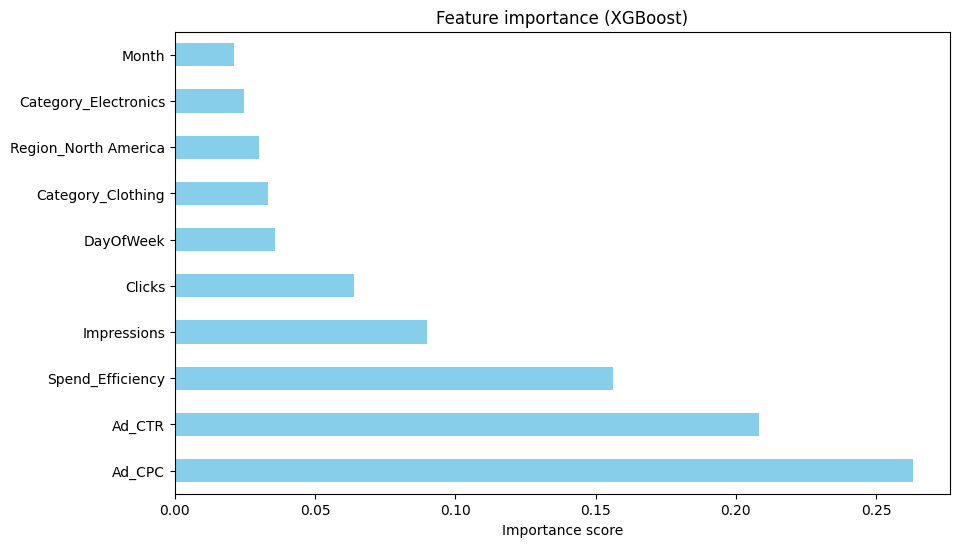

In [286]:
import matplotlib.pyplot as plt

importances = best_xgb.feature_importances_
feat_importances = pd.Series(importances, index=X.columns)

plt.figure(figsize=(10,6))
feat_importances.nlargest(10).plot(kind='barh', color='skyblue')
plt.title("Feature importance (XGBoost)")
plt.xlabel("Importance score")
plt.show()

In [287]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Final prediction on the tst set (which the model NEVER saw)
final_test_preds = best_xgb.predict(X_test_scaled)

test_r2 = r2_score(y_test, final_test_preds)
test_mae = mean_absolute_error(y_test, final_test_preds)
test_rmse = np.sqrt(mean_squared_error(y_test, final_test_preds))

print(f"--- FINAL TEST SET RESULTS ---")
print(f"R2 Score: {test_r2:.4f}")
print(f"MAE: ${test_mae:.2f}")
print(f"RMSE: ${test_rmse:.2f}")

--- FINAL TEST SET RESULTS ---
R2 Score: 0.5244
MAE: $1634.29
RMSE: $2273.93


In [288]:
bag_test_r2 = r2_score(y_test, bag_test_preds)
bag_test_mae = mean_absolute_error(y_test, bag_test_preds)
bag_test_rmse = np.sqrt(mean_squared_error(y_test, bag_test_preds))

print(f"--- BAGGING RF TEST SET RESULTS ---")
print(f"R2 Score: {bag_test_r2:.4f}")
print(f"MAE: ${bag_test_mae:.2f}")
print(f"RMSE: ${bag_test_rmse:.2f}")

--- BAGGING RF TEST SET RESULTS ---
R2 Score: 0.5037
MAE: $1678.93
RMSE: $2322.93


XGBoost is better

In [290]:
import numpy as np

# Train on log values
y_train_log = np.log1p(y_train)
best_xgb.fit(X_train_scaled, y_train_log)

# Predict and transform back to dollars
log_preds = best_xgb.predict(X_test_scaled)
final_preds = np.expm1(log_preds) # inverser log using exp

print(f"New R2: {r2_score(y_test, final_preds)}")
print(f"MAE: ${mean_absolute_error(y_test, final_test_preds)}")


New R2: 0.5103692168572471
MAE: $1634.2862791901468


Changed nothing significant

In [291]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# core Eval metrics
mae = mean_absolute_error(y_test, final_test_preds)
mape = mean_absolute_percentage_error(y_test, final_test_preds)

# Calculate 'accuracy' as 1 - MAPE
accuracy_pct = (1 - mape) * 100

# Calculate the 'Relative Error' against the Mean
mean_revenue = y_test.mean()
relative_error = (mae / mean_revenue) * 100

print(f"--- Objective Performance Metrics ---")
print(f"Mean Revenue in Test Set: ${mean_revenue:.2f}")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape*100:.2f}%")
print(f"--- Report Ready Statistics ---")
print(f"Predictive Accuracy (1-MAPE): {accuracy_pct:.2f}%")
print(f"Error as % of Mean Revenue: {relative_error:.2f}%")

--- Objective Performance Metrics ---
Mean Revenue in Test Set: $10161.77
Mean Absolute Error (MAE): $1634.29
Mean Absolute Percentage Error (MAPE): 17.64%
--- Report Ready Statistics ---
Predictive Accuracy (1-MAPE): 82.36%
Error as % of Mean Revenue: 16.08%


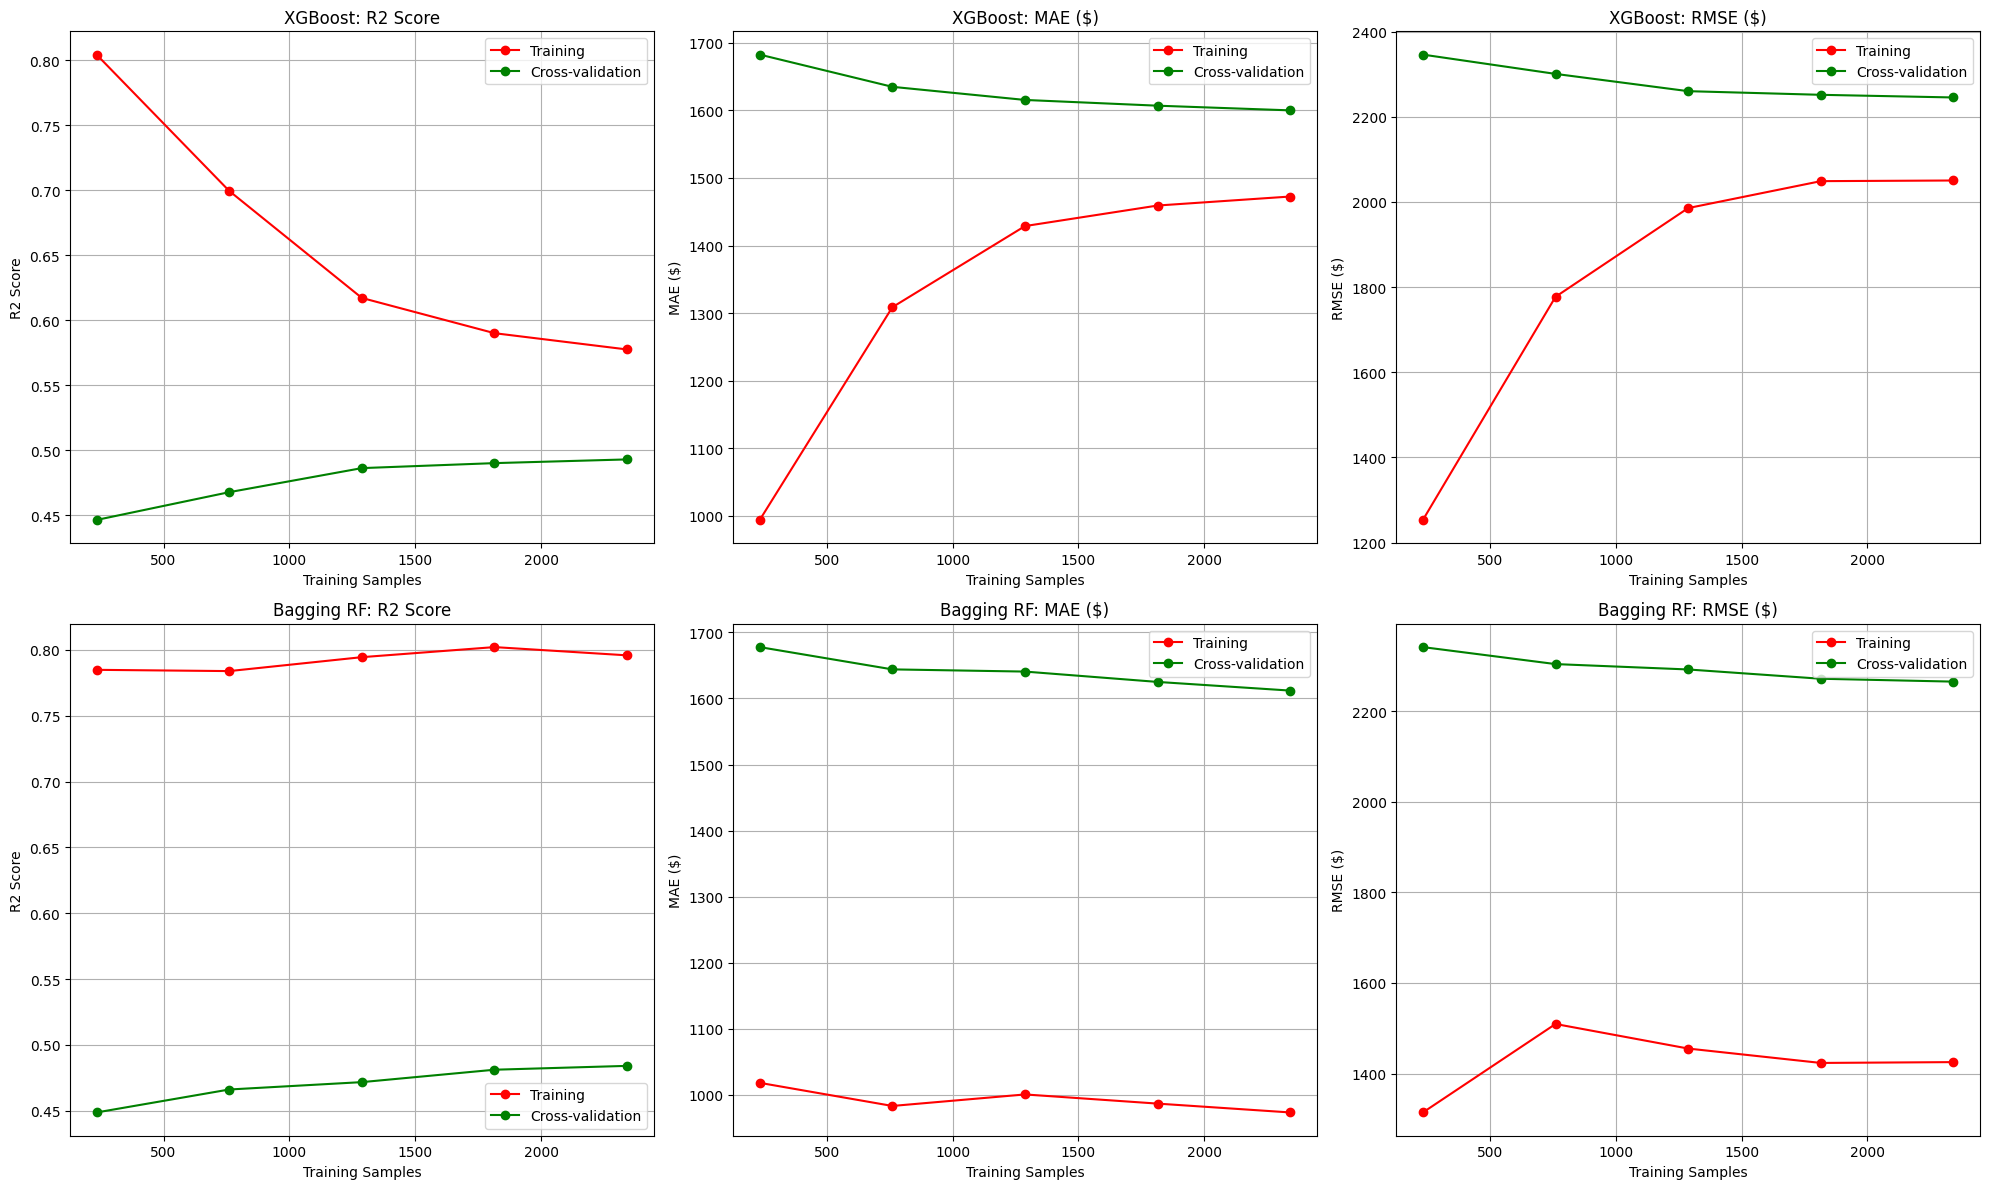

In [292]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

def plot_comprehensive_learning_curves(models, X, y):
    # Define RMSE scorer since it's not a default string option
    rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

    metrics = [
        ('r2', 'R2 Score', False),
        ('neg_mean_absolute_error', 'MAE ($)', True),
        (rmse_scorer, 'RMSE ($)', True)
    ]

    fig, axes = plt.subplots(len(models), len(metrics), figsize=(20, 12))

    for i, (name, model) in enumerate(models.items()):
        for j, (scorer, label, is_error_metric) in enumerate(metrics):
            train_sizes, train_scores, test_scores = learning_curve(
                model, X, y, cv=3, n_jobs=-1,
                train_sizes=np.linspace(0.1, 1.0, 5), scoring=scorer
            )

            # Convert negative scores back to positive for MAE and RMSE
            if is_error_metric:
                train_mean = -np.mean(train_scores, axis=1)
                test_mean = -np.mean(test_scores, axis=1)
            else:
                train_mean = np.mean(train_scores, axis=1)
                test_mean = np.mean(test_scores, axis=1)

            axes[i, j].plot(train_sizes, train_mean, 'o-', color="r", label="Training")
            axes[i, j].plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation")
            axes[i, j].set_title(f"{name}: {label}")
            axes[i, j].set_xlabel("Training Samples")
            axes[i, j].set_ylabel(label)
            axes[i, j].legend(loc="best")
            axes[i, j].grid(True)

    plt.tight_layout()
    plt.show()

# Run the function (Uses the 3513 training rows)
plot_comprehensive_learning_curves({"XGBoost": best_xgb, "Bagging RF": bag_rf}, X_train_scaled, y_train)

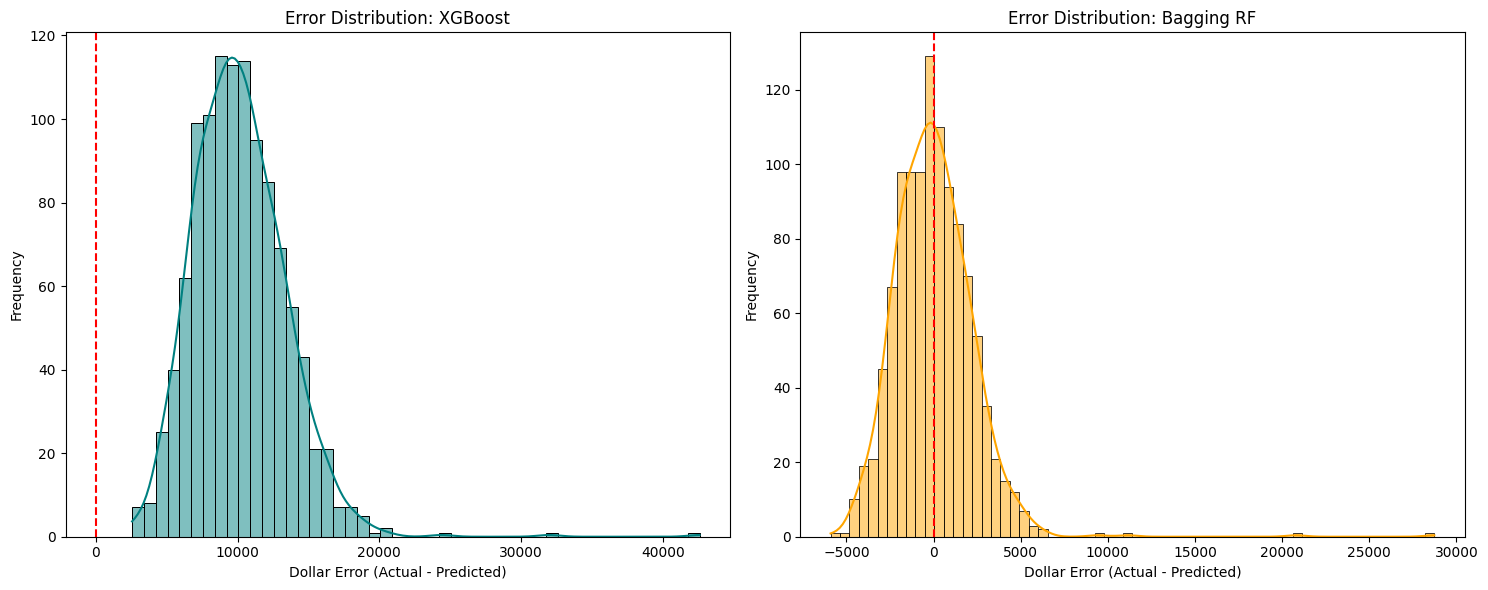

In [293]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_error_histograms(models, X_test, y_test):
    """
    Generates histograms of the prediction errors (residuals) for both models.
    """
    fig, axes = plt.subplots(1, len(models), figsize=(15, 6))

    for i, (name, model) in enumerate(models.items()):
        preds = model.predict(X_test)
        residuals = y_test - preds

        sns.histplot(residuals, kde=True, ax=axes[i], color='teal' if "XGB" in name else 'orange')
        axes[i].set_title(f"Error Distribution: {name}")
        axes[i].set_xlabel("Dollar Error (Actual - Predicted)")
        axes[i].set_ylabel("Frequency")

        # Add a vertical line at 0 (Perfect Prediction)
        axes[i].axvline(0, color='red', linestyle='--')

    plt.tight_layout()
    plt.show()

# Run for your models
plot_error_histograms({"XGBoost": best_xgb, "Bagging RF": bag_rf}, X_test_scaled, y_test)